# HINMINE

HINMINE [[1]](#fn1) (Heterogeneous Information Network Mining with Information Retrieval Heuristics) is a methodology for *decomposition* of heterogeneous information networks, e.g. networks consisting of multiple node and edge types. HINMINE operates on heterogeneous information networks (HINs). Formally, HINs can be defined as typed graphs as follows:

$\textrm{HIN} = (N, E, N_t, E_t),$

where $N$ is the set of nodes, $E$ the set of edges, $N_t$ the set of node types (each element of $N$ gets assigned a type from $N_t$) and edge types $E_t$ (each edge is assigned a type from $E_t$). The key idea of HINMINE can be summarised in the following two steps:
1. Network decomposition
2. Propositionalization

The first point (1.) attempts to simplify the initial $\textrm{HIN}$ into a graph $G = (N, E, w)$, where $w$ is a set of real-valued weights assigned to each edge from $E$ (one weight per edge). HINMINE achieves such decomposition by first selecting types of *meta paths* that shall be used for decomposition. Such paths are counted with respect to the number of times they link a given pair of nodes of interest, and aggregated.
More formally, given a heuristic function $f$, a weight of an edge between the two nodes $u$ and $v$ is computed as
$$ w(u,v) = \sum_{ \substack {m \in M \\ (u, m)\in E\\ (m, v)\in E}} f(m) $$


---
<span id="fn1"> [1] Kralj, J., Robnik-Šikonja, M. and Lavrač, N. HINMINE: heterogeneous information network mining with information retrieval heuristics. J Intell Inf Syst 50, 29–61 (2018). </span>

---

## Movie genre classification

In the following use case we will demonstrate how HINMINE can be adopted for the task of movie genre classification from a heterogeneous information network of movie actors, directors and movies. First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install py3plex==0.90
!pip -q install pandas==1.1.4
!pip -q install seaborn==0.11.0
!pip -q install tqdm==4.54.1
!pip -q install scikit-learn==0.23.2

Let's explore possible decomposition cycles (meta-paths used during counting). We download the [IMDB dataset](https://github.com/SkBlaz/py3plex/blob/master/datasets/imdb.gpickle) into a local folder `data`, load it, and begin the exploration. The dataset is stored as a pickled [`networkx.MultiDiGraph` object](https://networkx.org/documentation/stable/reference/classes/multidigraph.html).

In [2]:
from urllib.request import urlopen
from py3plex.core import multinet
import warnings
warnings.filterwarnings('ignore')

print("Obtaining the IMDB data set.")
data = urlopen('https://github.com/SkBlaz/py3plex/raw/master/datasets/imdb.gpickle')
with open('data/imdb.gpickle', 'wb') as fp:
    fp.write(data.read())

dataset = "data/imdb.gpickle"

print("Constructing a py3plex network object.")
# Construct a heterogeneous information network object
multilayer_network = multinet.multi_layer_network().load_network(
    input_file=dataset, directed=True, input_type=dataset.split(".")[-1])

# Show some basic statistics
multilayer_network.basic_stats()

Obtaining the IMDB data set.
Constructing a py3plex network object.
Parsing gpickle..
-------------------- 
 Computing core stats of the network 
 --------------------
Name: 
Type: MultiDiGraph
Number of nodes: 6384
Number of edges: 14592
Average in degree:   2.2857
Average out degree:   2.2857
Number of unique node IDs: 6342


Let's explore how edges look like in such a network. Each edge is composed of three main parts: node 1, node 2 and edge data. Note that nodes are in fact tuples `(id, type)`. In edge data, you can see that e.g., _acts_in_ and _features_ are two possible edge types.

In [3]:
first_edges = list(multilayer_network.get_edges(data=True))[0:10]
for edge in first_edges:
    print(edge)

(('ruthay', 'person'), ('movie_81', 'movie'), {'type': 'acts_in'})
(('movie_81', 'movie'), ('buddy_guy', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('william_denis', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('marshall_bell', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('chuck_bacino', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('jacob_berenger', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('fairuza_balk', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('michael_nicolosi', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('seymour_cassel', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('phil_boardman', 'person'), {'type': 'features'})


These were some examples of links. However, how are the nodes represented? Let's inspect the printout of a couple of examples next.

In [4]:
first_nodes = list(multilayer_network.get_nodes(data=True))[0:10]
for node in first_nodes:
    print(node)

(('ruthay', 'person'), {'type': 'person'})
(('movie_81', 'movie'), {'labels': 'Crime---Drama---Romance', 'type': 'movie', 'name': 'movie_things-to-do-in-denver-when-youre-dead'})
(('riwia_brown', 'person'), {'type': 'person'})
(('movie_290', 'movie'), {'labels': 'Crime---Drama', 'type': 'movie', 'name': 'movie_once-were-warriors'})
(('peter_brocco', 'person'), {'type': 'person'})
(('movie_189', 'movie'), {'labels': 'Comedy---Fantasy', 'type': 'movie', 'name': 'movie_the-reckless-moment'})
(('charles_s_dutton', 'person'), {'type': 'person'})
(('movie_89', 'movie'), {'labels': 'Action---Thriller', 'type': 'movie', 'name': 'movie_nick-of-time'})
(('movie_40', 'movie'), {'labels': 'Drama', 'type': 'movie', 'name': 'movie_cry-the-beloved-country'})
(('niall_obrien', 'person'), {'type': 'person'})


Each node is a tuple `(name, type)`, equipped with some additional information. Note that the _labels_ attribute is present only for the _movie_ type of nodes. Multiple labels can be assigned to an individual movie. The goal will be to learn to predict these labels (for unlabeled nodes).

Let's try to visualize this network next. We have two main types of nodes: humans and movies. We are interested in obtaining only the network consisting of the minority nodes (movies) by accounting for the majority ones (person).

Beginning parsing..
Using custom init positions!


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


BarnesHut Approximation  took  0.87  seconds
Repulsion forces  took  13.66  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


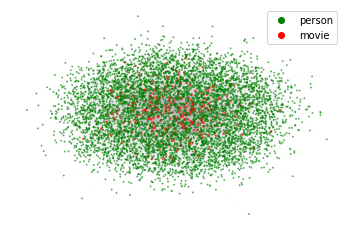

In [5]:
from py3plex.visualization.multilayer import hairball_plot
import numpy as np

# Assign the colors to nodes in consistent manner
color_list = []
for n in multilayer_network.core_network.nodes():
    if n[1] == "person":
        color_list.append("green")
    else:
        color_list.append("red")

hairball_plot(multilayer_network.core_network,
              color_list = color_list,
              layout_parameters = {"iterations": 5},
              scale_by_size = True,
              legend = True,
              layout_algorithm = "force")

## HINMINE methodology
In the remaining part of the notebook we will explore the key idea behind HINMINE, summarised as follows:
 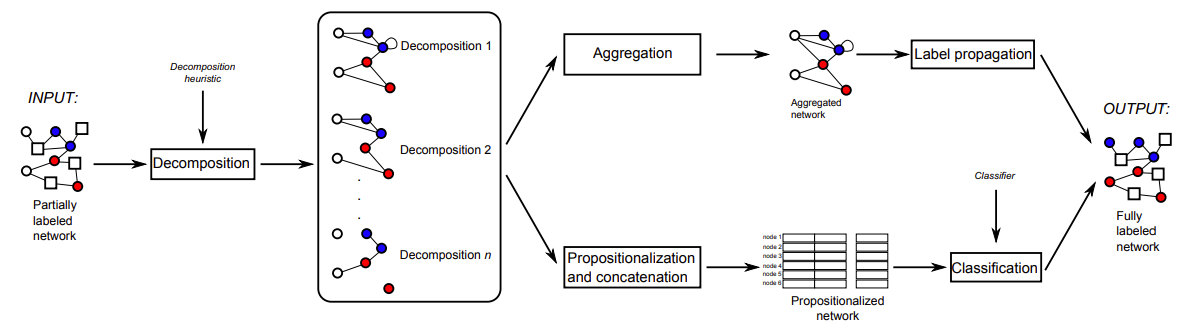

Key parts of the methodology can be described as follows. First, the `decomposition` step takes as input a _heterogeneous information network_ and outputs multiple possible _decompositions_, i.e., simple _homogeneous_ networks that are useful for down-stream learning -- in our case node classification. The second part of the methodology, i.e. `propositionalization and concatenation` learns rich representations of the nodes of interest based on different decompositions. Such _representations_ are finally concatenated for learning purposes.

Let's first identify possible decomposition cycles. These are just paths connecting the target node pairs, which are in this case "movie" types. Note that such paths are also commonly referred to as _meta paths_. HINMINE finds four relevant decomposition paths.

In [6]:
triplet_set = list(set(multilayer_network.get_decomposition_cycles()))
print("\n".join(triplet_set))

Target type: {'movie'}
movie_____features_____person_____acts_in_____movie
movie_____directed_by_____person_____directed_____movie
movie_____features_____person_____directed_____movie
movie_____directed_by_____person_____acts_in_____movie


Each row in the preceeding printout represents a single path. The first path, for example, can also be stated as:
$$\textrm{movie} \rightarrow^{\textrm{r1}} \textrm{person} \rightarrow^{\textrm{r2}} \textrm{movie}$$
where $\textrm{r1}$ represents the _directed by_ relation and $\textrm{r2}$ the _acts in_ relation. Note that these paths are _directed_. Intuitively, HINMINE offers the user to select _which_ paths will be used to derive weights between the target nodes of interest, inducing a simpler, _homnogeneous_ network that is suitable for machine learning.

We use the obtained decomposition paths to obtain a frequency-weighted (see `tf` heuristic) homogeneous networks of movies. The current implementation of HINMINE supports two distinct ways of decomposing a heterogeneous network:
1. **Single path-based decomposition** where individual paths induce separate networks.
2. **Multi path-based decomposition** where all paths are considered simultaneously when constructing the final weighted network.

The multipath variant of HINMINE can be summarised as follows:
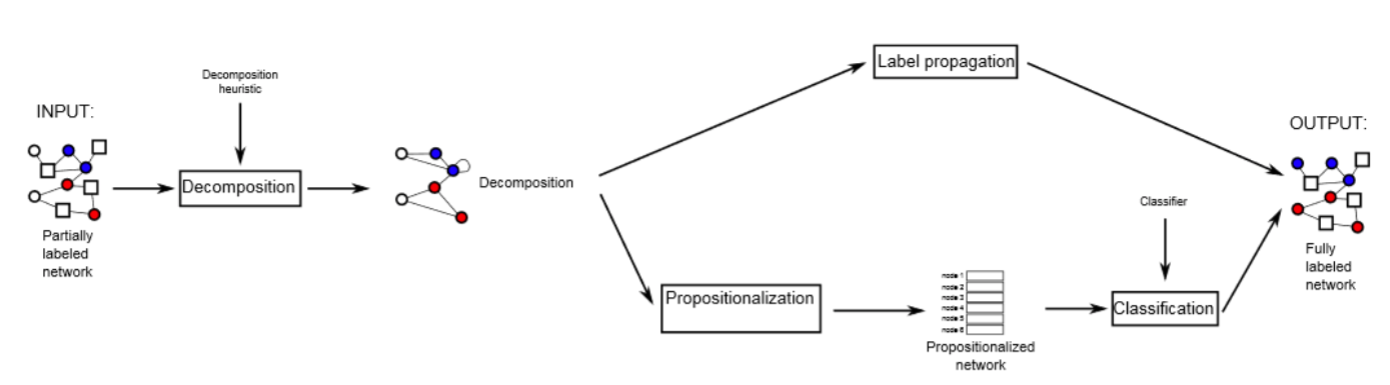

The user can select which type of decomposition to consider with the following flag:

In [7]:
## Decomposition settings

decomposition_type = "HINMINE-basic" # see the paper (scheme above)
#decomposition_type = "HINMINE-multipath" # simultaneous consideration of all paths.
# to use the multi-path HINMINE you can uncomment the line above.

decomposition_heuristic = "tf"

Next, we perform the decomposition.

In [8]:
import pandas as pd

decomposed_homogeneous_networks = [] ## the container for the decomposed homogeneous networks
decomposition_statistics = []        ## the container of network summary statistics

def parse_decomposition_result(decomposition):
        """
        A simple decomposition output parser method.
        
        :param decomposition: the decomposition object as returned by HINMINE framework
        """
        
        # The result is a list, one entry for each heuristic. As we have only "tf", we have only one item.
        decomposition = list(decomposition) # decomposition is a generator so this is mandatory
        
        # The network
        decomposed_network = decomposition[0]
        
        # Get the label matrix
        labels = decomposition[1] # The label matrix is the same for all decompositions
        
        # Maximum weight present
        maximum_weight = np.max(decomposed_network)

        # Compute some other statistics
        number_of_edges = np.count_nonzero(decomposed_network.todense())
    
        # Mean weight
        mean_weight = np.mean(decomposed_network)
        
        return decomposed_network, maximum_weight, mean_weight, number_of_edges, labels

if decomposition_type == "HINMINE-basic":
    
    print("Considering basic HINMINE version.")
    for triplet in triplet_set:
    
        print(f"Considering path {triplet}")
        # Get the decomposition. For other heuristics, see the HINMINE paper.
        decompositions = list(multilayer_network.get_decomposition(heuristic=[decomposition_heuristic], cycle = [triplet]))[0]
        
        # Parse results
        decomposed_network, maximum_weight, mean_weight, number_of_edges, labels = parse_decomposition_result(decompositions)
        
        # Populate the statistics dataframe
        decomposition_statistics.append([maximum_weight, mean_weight, number_of_edges, triplet.replace("____","->")])
        
        # Add the decomposed network to the network container
        decomposed_homogeneous_networks.append(decomposed_network)
        
elif decomposition_type == "HINMINE-multipath":
    
        print("Considering HINMINE multipath version.")
        decompositions = list(multilayer_network.get_decomposition(heuristic=[decomposition_heuristic], cycle = triplet_set))[0]

        # Parse results
        decomposed_network, maximum_weight, mean_weight, number_of_edges, labels = parse_decomposition_result(decompositions)
        
        # Populate the statistics dataframe
        decomposition_statistics.append([maximum_weight, mean_weight, number_of_edges, " AND ".join(triplet_set).replace("____","->")])
        
        # Add the decomposed network to the network container
        decomposed_homogeneous_networks.append(decomposed_network)
        
else:
    print("Please select avalid decomposition heuristic, either HINMINE-basic or HINMINE-multipath")
        
print(f"Decomposition resulted in {len(decomposed_homogeneous_networks)} networks.")

Considering basic HINMINE version.
Considering path movie_____features_____person_____acts_in_____movie
Considering path movie_____directed_by_____person_____directed_____movie
Considering path movie_____features_____person_____directed_____movie
Considering path movie_____directed_by_____person_____acts_in_____movie
Decomposition resulted in 4 networks.


What about some overall statistics of these networks?

In [9]:
dataframe_object = pd.DataFrame(decomposition_statistics)
dataframe_object.columns = ['Maximum weight value', "Mean weight value",'number of edges','decomposition triplet']
dataframe_object

,Maximum weight value,Mean weight value,number of edges,decomposition triplet
0,33.0,0.060493,3216,movie->_features->_person->_acts_in->_movie
1,34.0,0.061422,3243,movie->_directed_by->_person->_directed->_movie
2,68.0,0.123457,3281,movie->_features->_person->_directed->_movie
3,102.0,0.185491,3281,movie->_directed_by->_person->_acts_in->_movie


The statistics of the decomposed networks (weight spaces) indicate that different _meta paths_ yield different outcomes. The next goal is to include all obtained networks in the final learning phase.

The obtained decomposition is a *homogeneous network*. This means that all existing machinery, suitable for working with this type of networks is now possible to use. Kralj et al. [[1]](#fn1) exploited the Personalized PageRank algorithm for learning node representations. Here, a personalized PageRank vector is computed for each node, and *concatenated* to obtain the final representation. Note that this representation serves the same purpose as e.g., node2vec vectors.

In [10]:
# We first import some additional functionality from the py3plex library (and sklearn, which was installed as part of py3plex!)
from py3plex.algorithms.network_classification import PPR
import tqdm

def return_propositionalized_representation(decomposed_homogeneous_networks):
    """
    A method for propositionalization and concatenation of multiple networks.
    """
    
    matrix_container = []
    for decomposed_network in tqdm.tqdm(decomposed_homogeneous_networks):
        individual_vectors = PPR.construct_PPR_matrix(decomposed_network)
        matrix_container.append(individual_vectors)
        
    vectors = np.hstack(matrix_container)
    return vectors

if len(decomposed_homogeneous_networks) == 1:
    vectors = PPR.construct_PPR_matrix(decomposed_homogeneous_networks[0])
    
else:
    vectors = return_propositionalized_representation(decomposed_homogeneous_networks)
    
print(f"Propositionalization finished, final feature space is of dimension {vectors.shape}")

100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Propositionalization finished, final feature space is of dimension (297, 1188)


At this point, we have the `vectors` object that represents individual nodes of interest, and `labels` matrix which defines which labels correspond to a given node.

The obtained dense matrix can be used for down-stream learning. Let's classify the first genre with the SVM.

In [11]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import cross_val_score

## target space
Y = labels[:,0]
clf = SVC() # Let's use default SVM learner.
cross_val_scores = cross_val_score(clf, vectors, Y, cv=10, scoring = "accuracy")
print("The SVM scored with {} +-({})".format(np.mean(cross_val_scores), np.std(cross_val_scores)))

The SVM scored with 0.855287356321839 +-(0.01449780280481359)


What about other heuristics?

In [12]:
## Let's make an evaluation function
import pandas as pd
import seaborn as sns
import tqdm
from sklearn.multiclass import OneVsRestClassifier


def get_evaluated_heuristic(network, heuristic_name):
    
    homogeneous_networks = []
    
    # Obtain decompositions
    for unique_path in triplet_set:
        decomposition = list(multilayer_network.get_decomposition(heuristic=[heuristic_name], cycle = [unique_path]))[0]
        homogeneous_networks.append(decomposition[0])
   
    # Final feature matrix (via PPR)
    vectors = return_propositionalized_representation(homogeneous_networks)
    
    # target space
    Y = labels
    
    # classifier OVR in this case
    clf = OneVsRestClassifier(SVC()) # Let's use default SVM learner.
    
    # get the score
    cross_val_scores = cross_val_score(clf, vectors, Y, cv=3, scoring = "accuracy") # Subset accuracy, see
    # Ghamrawi, Nadia, and Andrew McCallum. "Collective multi-label classification." 
    # Proceedings of the 14th ACM international conference on Information and knowledge management. ACM, 2005.
    
    return np.mean(cross_val_scores)

heuristic_results = []
for heuristic in ["idf", "tf", "chi", "ig", "gr", "delta", "rf", "okapi"]:
    score = get_evaluated_heuristic(multilayer_network, heuristic);
    heuristic_results.append([heuristic, score])
    
final_dataframe = pd.DataFrame(heuristic_results)
final_dataframe.columns = ['Heuristic','Accuracy']

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


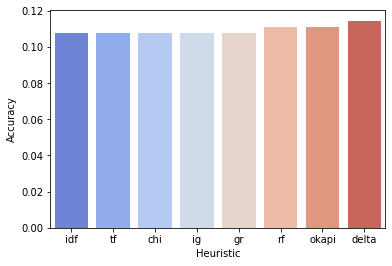

In [13]:
final_dataframe = final_dataframe.sort_values(by = ['Accuracy'])
_ = sns.barplot(final_dataframe.Heuristic, final_dataframe.Accuracy, palette = "coolwarm")

The heuristics are defined as follows. The $B$ defines the set of all nodes of the base type (e.g., `movies`) and $E$ all edges of the heterogeneous network. Let $m$ represent a node; then, $P(m)$ represents the probability of observing a random based node linked to $m$. The $C$ represents the set of classes. The $P(c)$ denotes the probability that a random node is in class $c$. THe term $P(c \wedge m)$ corresponds to the probability of a given node being linked to an intermediary node $m$, as well as being labaled with $c$. Note that _bm25_ is a synonym for _okapi_.

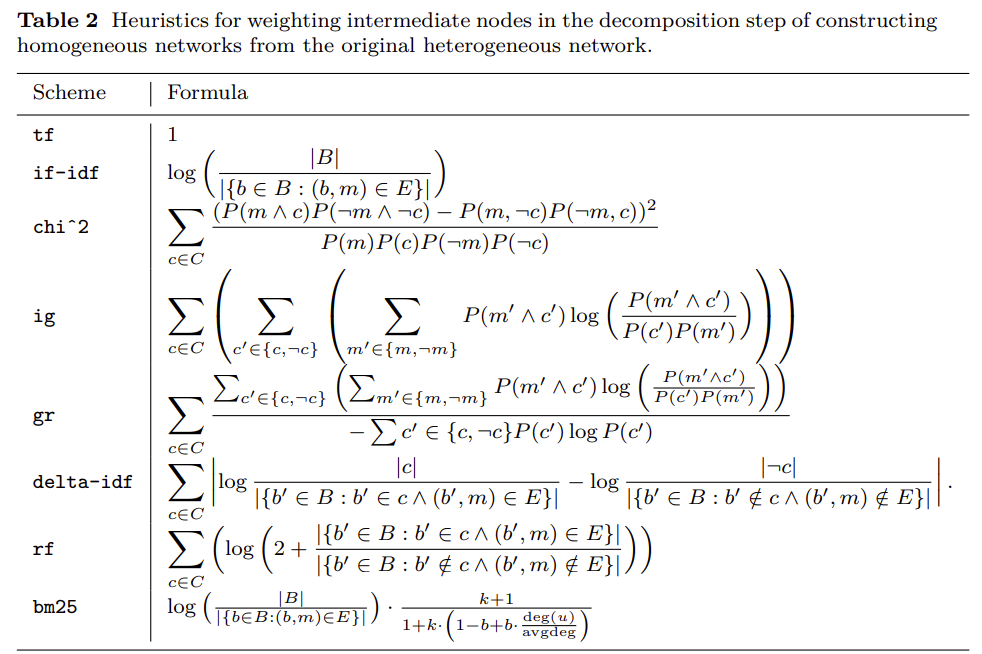